In [1]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import random
from transformers import ViTFeatureExtractor, ViTModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import optuna

In [3]:
image_path_1 = r'C:\Users\ASUS\Downloads\N_20250210_extn_blmrbl_hires_v3.0.png'
image_path_2 = r'C:\Users\ASUS\Downloads\no data.png'

img1 = cv2.imread(image_path_1)
img2 = cv2.imread(image_path_2)

# NO DATA text Detection for Handling Images with Missing Data

*   'NO DATA' text is detected in an image using OCR
*   Images used in image_path_1 and image_path_2 can be found in folder DIP_Predicting_SIE
/sample_image with the same name mentioned in the code.




Detected Text from Final Enhanced Image in C:\Users\ASUS\Downloads\N_20250210_extn_blmrbl_hires_v3.0.png:



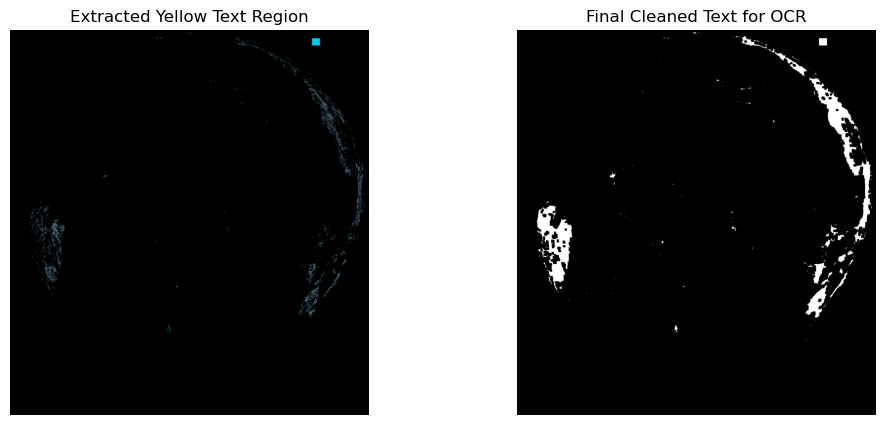

Detected Text from Final Enhanced Image in C:\Users\ASUS\Downloads\no data.png:
NO
' '



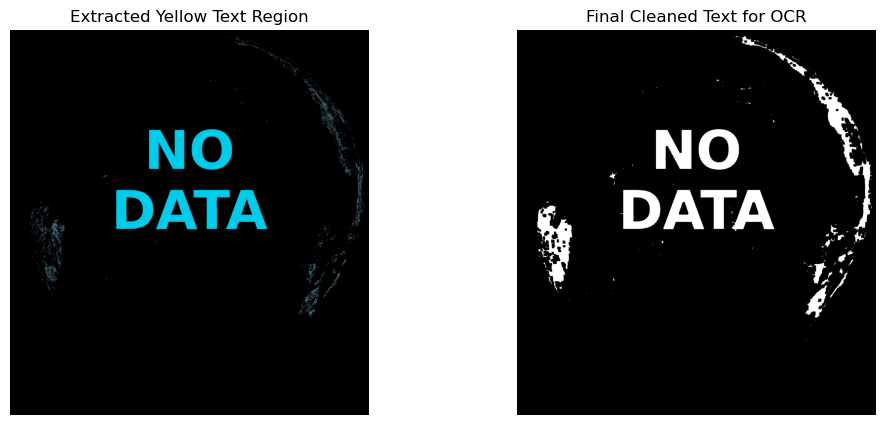

Skipping C:\Users\ASUS\Downloads\no data.png: NO DATA detected.
Image 1 (N_20250210): Valid Image
Image 2 (no data): NO DATA detected


In [5]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def extract_yellow_text_region(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])

    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_text_region = cv2.bitwise_and(image, image, mask=mask)

    return yellow_text_region

def enhance_text_for_ocr(text_region):
    gray = cv2.cvtColor(text_region, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    return cleaned

def is_no_data_image(image_path):
    """ Detects 'NO DATA' in an image using OCR on enhanced yellow text. """
    img = cv2.imread(image_path)

    yellow_text = extract_yellow_text_region(img)

    enhanced_text = enhance_text_for_ocr(yellow_text)

    #character whitelist
    custom_oem_psm = "--oem 3 --psm 6 -c tessedit_char_whitelist='NO DATA'"

    text = pytesseract.image_to_string(enhanced_text, config=custom_oem_psm)

    print(f"Detected Text from Final Enhanced Image in {image_path}:\n{text}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(yellow_text)
    axes[0].set_title("Extracted Yellow Text Region")
    axes[0].axis("off")

    axes[1].imshow(enhanced_text, cmap="gray")
    axes[1].set_title("Final Cleaned Text for OCR")
    axes[1].axis("off")

    plt.show()

    if "NO" in text.upper():
        print(f"Skipping {image_path}: NO DATA detected.")
        return True

    return False

image_path_1 = r'C:\Users\ASUS\Downloads\N_20250210_extn_blmrbl_hires_v3.0.png'
image_path_2 = r'C:\Users\ASUS\Downloads\no data.png'  # image with no data text

no_data_1 = is_no_data_image(image_path_1)
no_data_2 = is_no_data_image(image_path_2)

print(f"Image 1 (N_20250210): {'NO DATA detected' if no_data_1 else 'Valid Image'}")
print(f"Image 2 (no data): {'NO DATA detected' if no_data_2 else 'Valid Image'}")


# Image Pre Processing Steps



2025


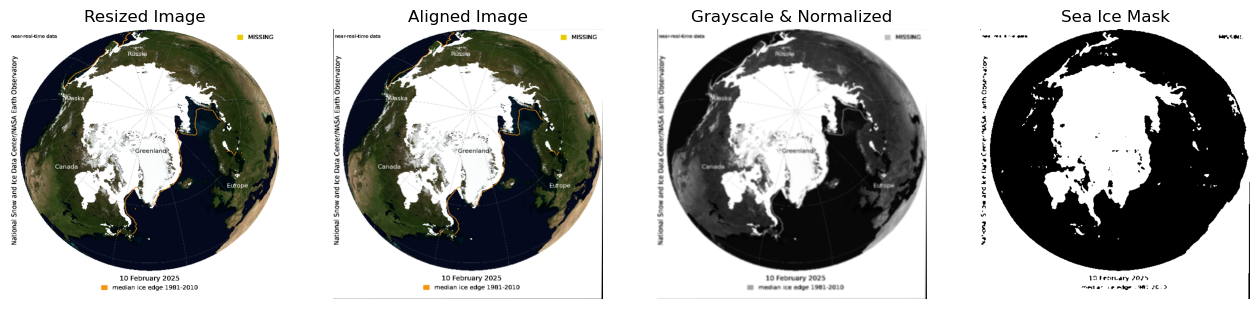

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_image(image, target_size=(512, 512)):
    """Resizes the image to a fixed size (512x512) for consistency."""
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    return resized

def align_images(img1, img2):
    """Aligns img1 to img2 using ORB feature detection and homography."""
    orb = cv2.ORB_create()

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    aligned_img = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))

    return aligned_img

def denoise_image(image):
    """Applies Gaussian blur to reduce sensor noise and atmospheric distortions."""
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred

def grayscale_and_normalize(image):
    """Converts an image to grayscale and normalizes contrast for uniformity."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    normalized = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    return normalized

def extract_sea_ice(image):
    """Segments ice regions from land and ocean using Otsu's thresholding."""
    _, binary_mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_mask

def preprocess_image(image_path, reference_image_path=None):
    """Applies all preprocessing steps on a given image."""
    img = cv2.imread(image_path)

    resized_img = resize_image(img)

    if reference_image_path:
        ref_img = cv2.imread(reference_image_path)
        ref_img_resized = resize_image(ref_img)
        aligned_img = align_images(resized_img, ref_img_resized)
    else:
        aligned_img = resized_img

    denoised_img = denoise_image(aligned_img)

    grayscale_img = grayscale_and_normalize(denoised_img)

    ice_mask = extract_sea_ice(grayscale_img)

    fig, axes = plt.subplots(1, 4, figsize=(16, 5))

    axes[0].imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Resized Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Aligned Image")
    axes[1].axis("off")

    axes[2].imshow(grayscale_img, cmap="gray")
    axes[2].set_title("Grayscale & Normalized")
    axes[2].axis("off")

    axes[3].imshow(ice_mask, cmap="gray")
    axes[3].set_title("Sea Ice Mask")
    axes[3].axis("off")

    plt.show()

    return ice_mask

image_path = r'C:\Users\ASUS\Downloads\N_20250210_extn_blmrbl_hires_v3.0.png'
reference_image_path = r'C:\Users\ASUS\Downloads\N_20250101_extn_blmrbl_hires_v3.0.png'

print(2025)
processed_mask = preprocess_image(image_path, reference_image_path)


# Feature Extraction Example
*   Images used in previous_year_image_path and current_image_path can be found in folder DIP_Predicting_SIE



Reference Image of Previous Years


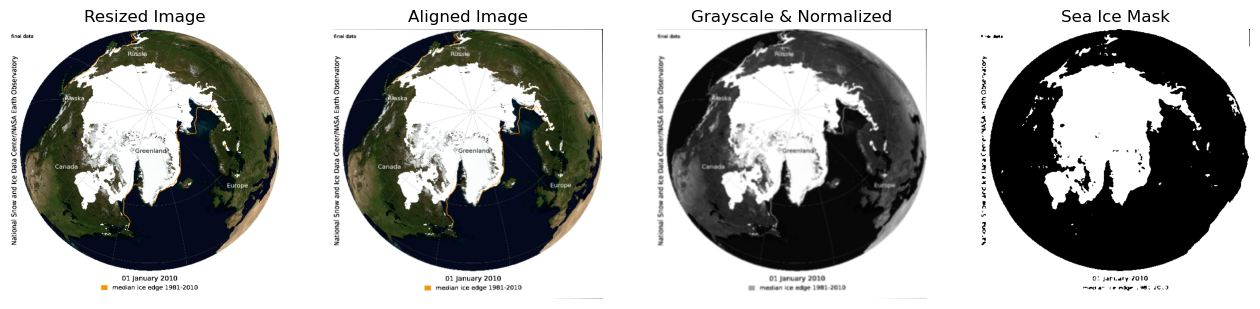

Current Year Image


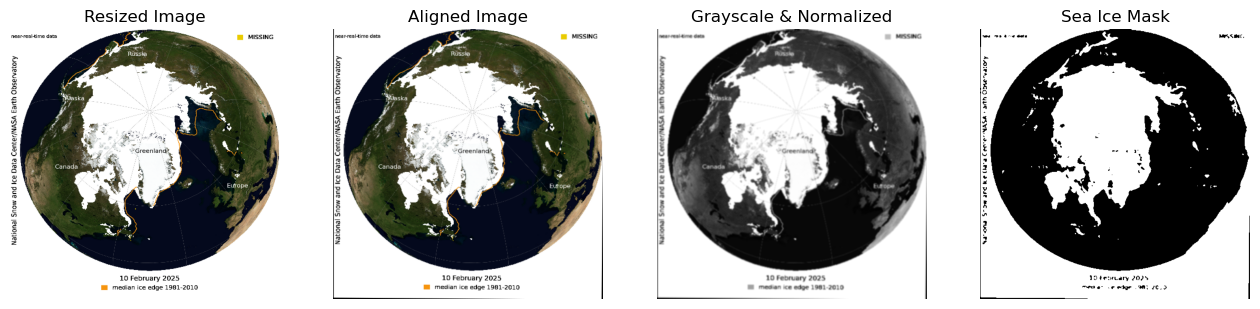

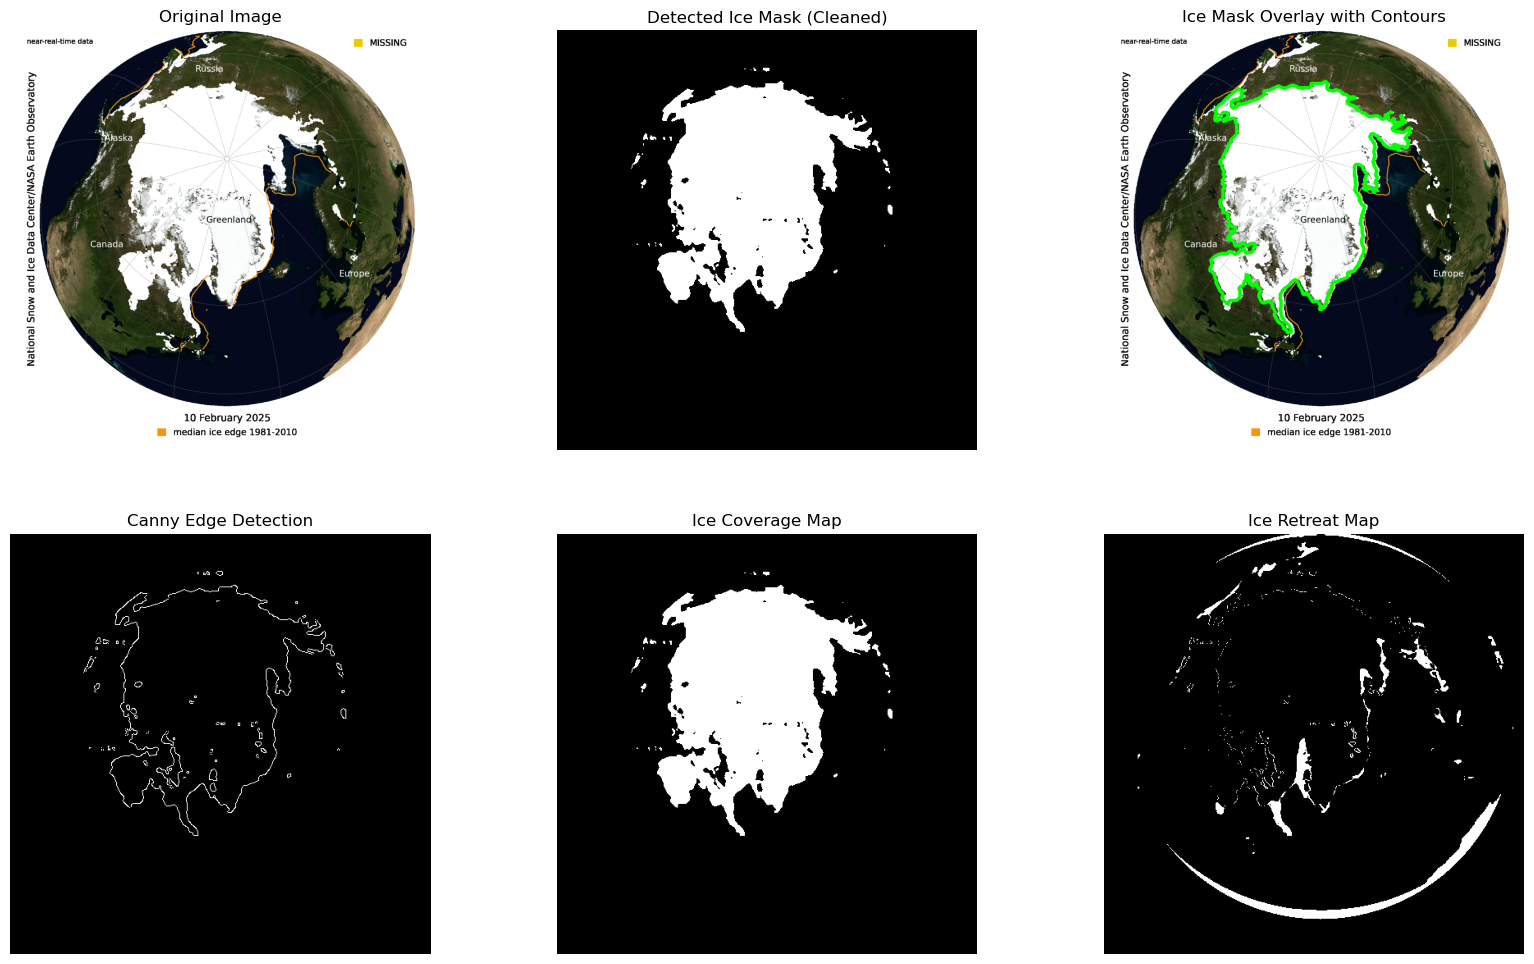

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def detect_globe_boundary(image):
    """Automatically detects the circular boundary of the globe to remove background artifacts."""

    if len(image.shape) == 2:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detecting edges to find the circular boundary
    edges = cv2.Canny(blurred, 50, 150)

    # Finding contours and select the largest circle-like object
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No contours detected for the globe boundary!")

    max_contour = max(contours, key=cv2.contourArea)

    # getting enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(max_contour)
    return int(x), int(y), int(radius)

def apply_circular_mask(image):
    """Applying a precise circular mask to remove background"""
    h, w = image.shape[:2]
    x, y, radius = detect_globe_boundary(image)

    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (x, y), radius - 10, 255, -1)

    return cv2.bitwise_and(image, image, mask=mask)

def detect_edges(image):
    """Applying Canny Edge Detection to get ice boundaries."""
    return cv2.Canny(image, threshold1=30, threshold2=120)

def calculate_ice_area(image):
    """Calculating total ice-covered area in the image"""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = []
    ice_area = 0
    total_area = image.shape[0] * image.shape[1]

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 500 < area < (total_area * 0.85):
            ice_area += area
            filtered_contours.append(cnt)

    ice_percentage = (ice_area / total_area) * 100
    return ice_percentage, filtered_contours


def track_ice_retreat(image_old, image_new):
    """Finding changes in ice coverage between two images using image subtraction."""
    diff = cv2.absdiff(image_old, image_new)
    _, diff_mask = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
    return diff_mask

def visualize_all(original_image, binary_mask, contours, edges, ice_coverage_map, retreat_map):
    """visualization of all the steps"""

    overlay = original_image.copy()

    h, w = original_image.shape[:2]
    scaling_factor = w / binary_mask.shape[1]

    resized_contours = [np.int32(cnt * scaling_factor) for cnt in contours]

    center_x, center_y = w // 2, h // 2

    if resized_contours:
        x_min, y_min, w_box, h_box = cv2.boundingRect(np.vstack(resized_contours))
        x_shift, y_shift = center_x - (x_min + w_box // 2), center_y - (y_min + h_box // 2)

        y_shift -= 160

        x_shift -= 18

        scale_x = 1.003
        scale_y = 1.08

        stretched_contours = [
            np.int32(((cnt - [x_min, y_min]) * [scale_x, scale_y]) + [x_min, y_min] + [x_shift, y_shift])
            for cnt in resized_contours
        ]
    else:
        stretched_contours = resized_contours

    cv2.drawContours(overlay, stretched_contours, -1, (0, 255, 0), thickness=12)

    plt.figure(figsize=(20, 12))

    #  Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    #  Binary Ice Mask
    plt.subplot(2, 3, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Detected Ice Mask (Cleaned)")
    plt.axis("off")

    #  Ice Mask with Contours
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Ice Mask Overlay with Contours")
    plt.axis("off")

    #  Canny Edge Detection
    plt.subplot(2, 3, 4)
    plt.imshow(edges, cmap="gray")
    plt.title("Canny Edge Detection")
    plt.axis("off")

    #  Ice Coverage Map
    plt.subplot(2, 3, 5)
    plt.imshow(ice_coverage_map, cmap="gray")
    plt.title("Ice Coverage Map")
    plt.axis("off")

    #  Ice Retreat Map
    plt.subplot(2, 3, 6)
    plt.imshow(retreat_map, cmap="gray")
    plt.title("Ice Retreat Map")
    plt.axis("off")

    plt.show()



def extract_features(original_image, ice_mask, reference_mask=None):
    """Extracts key sea ice features and provides full visualization."""

    #  applying circular mask
    ice_mask = apply_circular_mask(ice_mask)

    #  edge detection
    edges = detect_edges(ice_mask)

    #  extracting contours
    ice_coverage, contours = calculate_ice_area(ice_mask)

    #  ice coverage map
    ice_coverage_map = (ice_mask > 0).astype(np.uint8) * 255

    #  ice retreat calculation
    if reference_mask is not None:
        reference_mask = apply_circular_mask(reference_mask)
        retreat_map = track_ice_retreat(reference_mask, ice_mask)
        retreat_area = np.sum(retreat_map > 0) / (retreat_map.shape[0] * retreat_map.shape[1]) * 100
    else:
        retreat_map = np.zeros_like(ice_mask)
        retreat_area = 0

    # all visualizations
    visualize_all(original_image, ice_mask, contours, edges, ice_coverage_map, retreat_map)

    return ice_coverage, retreat_area, edges, retreat_map


previous_year_image_path = r'C:\Users\ASUS\Downloads\N_20100101_extn_blmrbl_hires_v3.0.png'
current_image_path = r'C:\Users\ASUS\Downloads\N_20250210_extn_blmrbl_hires_v3.0.png'


original_image = cv2.imread(current_image_path)
if original_image is None:
    raise FileNotFoundError(f"Image not found: {current_image_path}")


print('Reference Image of Previous Years')
reference_mask = preprocess_image(previous_year_image_path, current_image_path)
print('Current Year Image')
processed_mask = preprocess_image(current_image_path, previous_year_image_path)

# feature extraction & visualization
ice_coverage, retreat_area, edges, retreat_map = extract_features(original_image, processed_mask, reference_mask)

